# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и анализ данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [2]:
autos = pd.read_csv('autos.csv')

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные оказались неполными, с неверными типами данных и полными аномалиями. Исправим это.

### Предобработка данных

In [6]:
autos = autos.drop('NumberOfPictures', axis=1)

Удалим столбец, так как он полностью состоит из нулей. Похоже, что проблема в датасете.

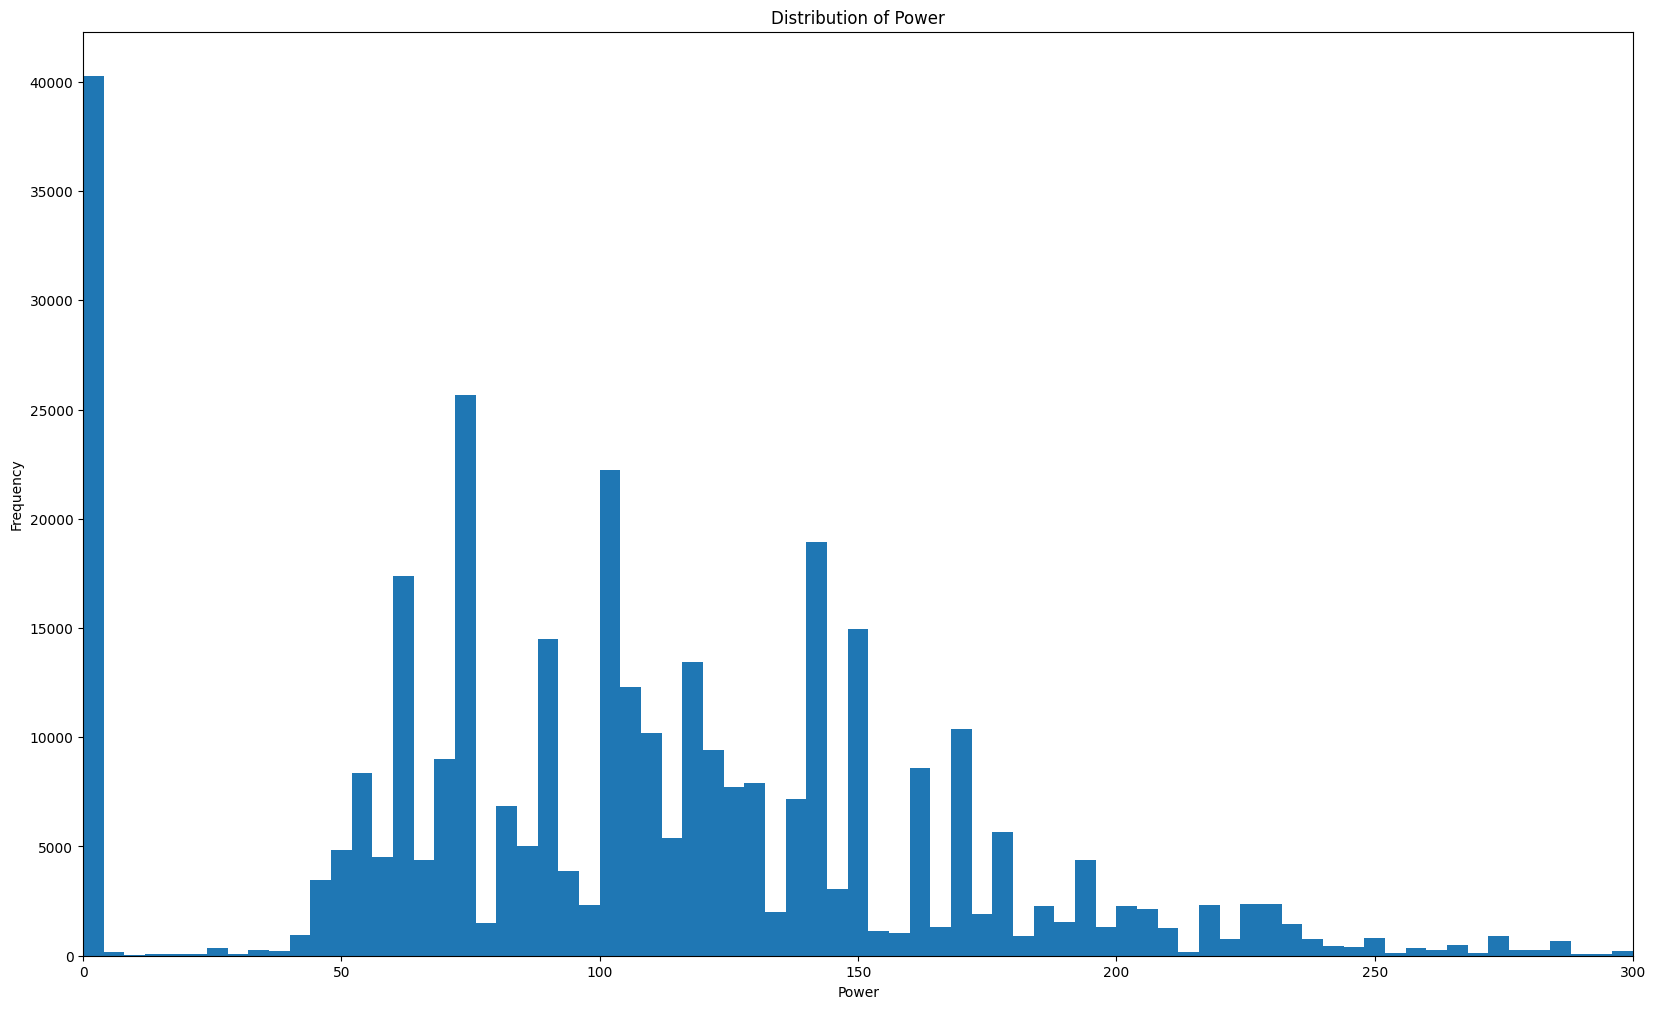

In [7]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim([0, 300])
ax.hist(autos['Power'], bins=5000)
ax.set_title('Distribution of Power')
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
plt.show()

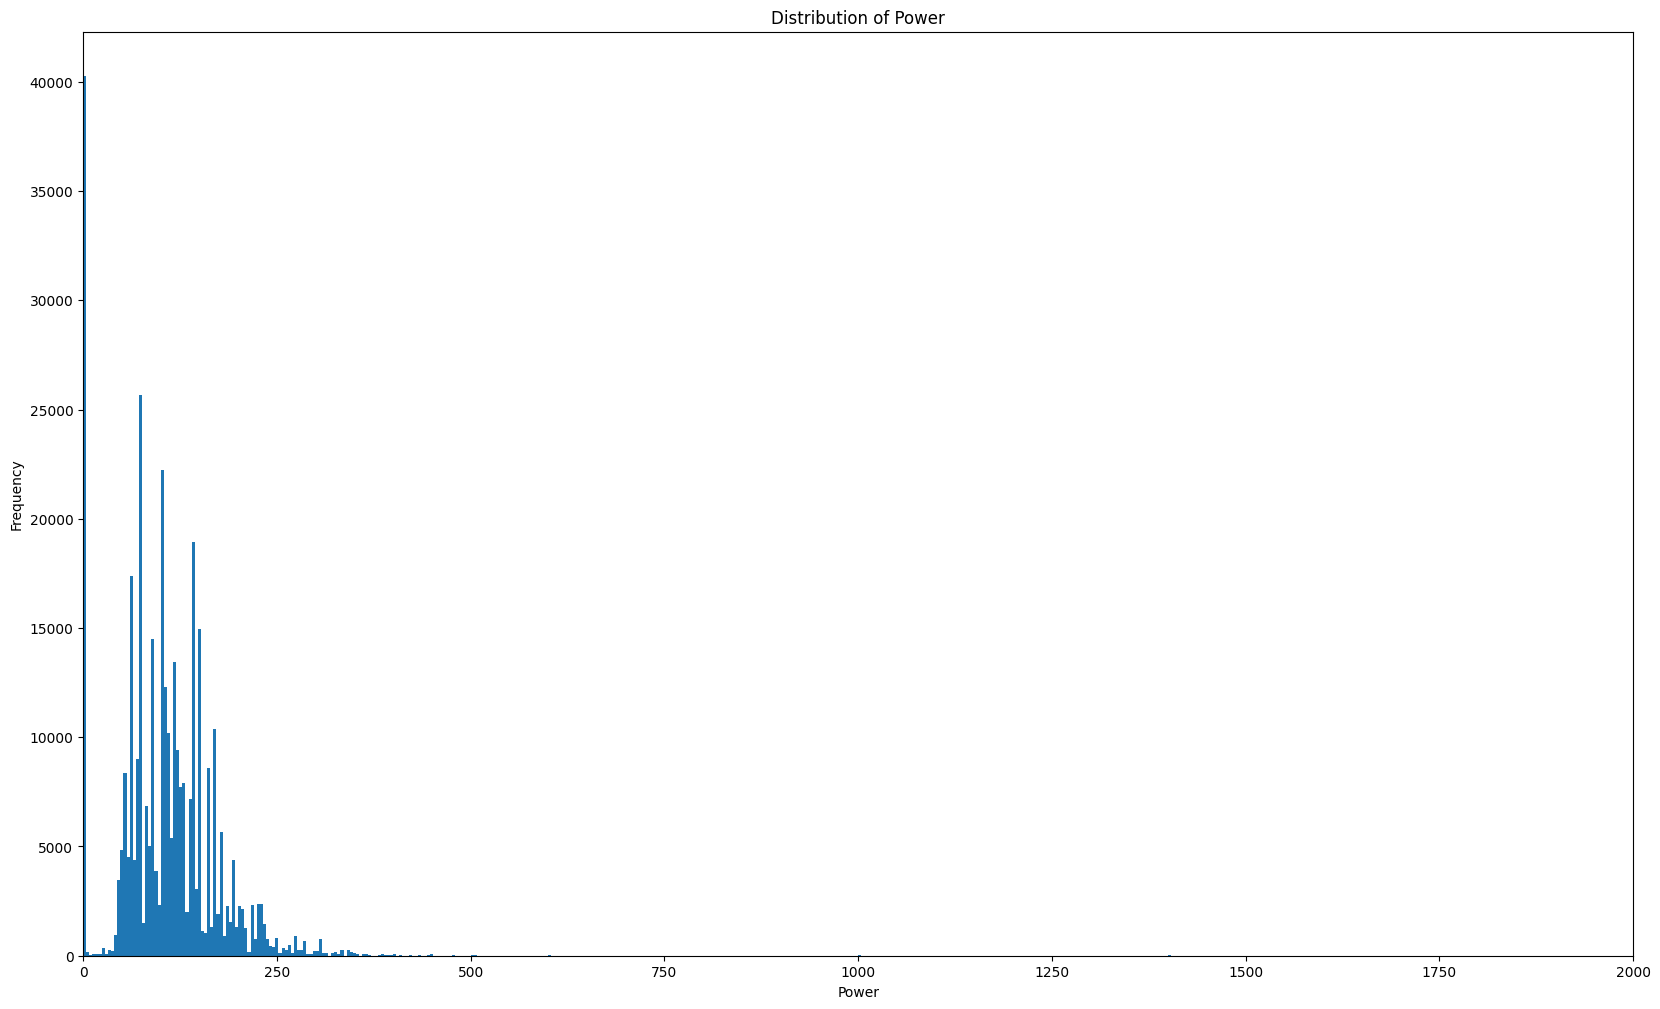

In [8]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim([0, 2000])
ax.hist(autos['Power'], bins=5000)
ax.set_title('Distribution of Power')
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
plt.show()

Действительно, графики показывают, что аномалии присутствуют.

In [9]:
autos = autos[autos['Power'] >= 40]

Уберем все двигатели с л.с. меньше 40.

In [10]:
autos = autos[autos['Power'] <= 600]

Также мы можем видеть аномалии с слишком мощными двигателями. 75-я процентиль показывает отметку в 143 л.с., но мы выставим планку в 600 л.с в расчёте на то, что на рынке могут встретиться модели топ-класса и кастомные сборки авто.

In [11]:
autos = autos.drop('PostalCode', axis=1)

Можно подумать, что почтовый индекс - очень полезная информация для предсказания цены, так как в зависимости от страны цены на автомобили могут разниться. Но суть в том, что одинаковый почтовый индекс может по разному трактоваться. Он может одновременно принадлежать как одной стране, так и другой. Он более полезен, когда известна страна, в этом случае он позволит знать регион/край/штат/область, чтобы вернее предсказывать цену, но увы, такой информацией мы не обладаем (мы можем предположить, что это Европа, так как цены в евро, но у каждой европейской страны свой zip-code), поэтому было принято решение удалить столбец с этими почтовыми кодами.

In [12]:
autos = autos[autos['RegistrationYear'] <= 2016]
autos = autos[autos['RegistrationYear'] >= 1885]

В некоторых объявлениях год регистрации указан выше 2016 года, что не может быть правдой, так как год скачивания базы данных - 2016. В некоторых случаях заметна ошибка со стороны техники, как год 1000 или 9999 (возможно, во время экспорта данных что-то пошло не так), а в других ошибки, созданные рукой человека (возможная опечатка в 2017, 2018, 2019 и т.д. годах регистрации автомобилей). В любом случае мы приняли решение удалить строки с такими данными, так как восстановить истинную информацию о годе регистрации автомобиля не представляется возможным, да и большого количества данных мы не потеряем.

In [13]:
autos = autos[autos['Price'] >= 100]

Также цены на некоторых объявлениях не всегда выглядят правдоподобно. 1 или даже 0 евро очень странная цена для продажи автомобиля, хотя скорее всего время от времени действительно появляются щедрые люди, раздающие свои автомобили на таких сайтах (хотя проблема скорее всего опять же в ошибках при экспорте данных), но и такие случаи лучше не включать в статистику. Мы удалили все строки с данными об автомобилях дешевле 100 евро.

In [14]:
autos = autos.drop(['DateCrawled', 'LastSeen'], axis=1)

Типы данных в этих столбцах с данными не пришлось изменять, так как мы удалили их. Это было сделано по причине того, что эти данные с очень малой вероятностью влияют на цену автомобиля.

In [15]:
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])

Изменили тип данных с `object` на `datetime`.

In [16]:
autos['DaysSinceCreated'] = (datetime.today() - autos['DateCreated']).dt.days

Мы посчитали, что время существования объявления на сайте теоретически может влиять на цену, поэтому перевели дату в дни (от выставки объявления до сегодняшнего дня).

In [17]:
autos = autos.drop(['DateCreated'], axis=1)

Этот столбец уже не понадобится.

In [18]:
autos['Brand'].value_counts()

volkswagen        63681
opel              32287
bmw               32139
mercedes_benz     27278
audi              25556
ford              20581
renault           13808
peugeot            9376
fiat               7407
seat               5816
skoda              4938
mazda              4711
smart              4459
citroen            4164
nissan             4025
toyota             4008
hyundai            3102
mini               2961
volvo              2817
mitsubishi         2484
honda              2356
kia                2081
alfa_romeo         1970
suzuki             1939
sonstige_autos     1598
chevrolet          1457
chrysler           1159
dacia               799
subaru              638
porsche             624
daihatsu            603
jeep                579
saab                472
land_rover          464
jaguar              436
daewoo              407
lancia              377
rover               361
lada                157
trabant              19
Name: Brand, dtype: int64

Дубликатов среди брендов машин найдено не было.

In [19]:
autos['Model'] = autos['Model'].fillna('Unknown')

autos['VehicleType'] = autos.groupby(['Brand', 'Model'], group_keys=False)['VehicleType'].apply(lambda x: x.fillna(x.mode().iloc[0]))

autos['Gearbox'] = autos.groupby(['Brand', 'Model'], group_keys=False)['Gearbox'].apply(lambda x: x.fillna(x.mode().iloc[0]))

autos['FuelType'] = autos.groupby(['Brand', 'Model'], group_keys=False)['FuelType'].apply(lambda x: x.fillna(x.mode().iloc[0]))

autos['Repaired'] = autos['Repaired'].fillna('Unknown')

autos = autos.reset_index(drop=True)

Заменили тип кузова, тип коробки передач и тип топлива, основываясь на марке и модели. Неуказанные марки и статус ремонта указали как `Unknown`.

In [20]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DaysSinceCreated
0,18300,coupe,2011,manual,190,Unknown,125000,5,gasoline,audi,yes,2650
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown,2660
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2657
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2643
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2639


In [21]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294094 entries, 0 to 294093
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              294094 non-null  int64 
 1   VehicleType        294094 non-null  object
 2   RegistrationYear   294094 non-null  int64 
 3   Gearbox            294094 non-null  object
 4   Power              294094 non-null  int64 
 5   Model              294094 non-null  object
 6   Kilometer          294094 non-null  int64 
 7   RegistrationMonth  294094 non-null  int64 
 8   FuelType           294094 non-null  object
 9   Brand              294094 non-null  object
 10  Repaired           294094 non-null  object
 11  DaysSinceCreated   294094 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 26.9+ MB


In [22]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DaysSinceCreated
count,294094.000000,294094.000000,294094.000000,294094.000000,294094.000000,294094.000000
mean,4879.082338,2002.899933,121.065030,128488.034438,6.002503,2653.194145
std,4613.799229,6.384191,53.607164,36531.385117,3.579846,9.327965
min,100.000000,1910.000000,40.000000,5000.000000,0.000000,2636.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,3.000000,2645.000000
50%,3200.000000,2003.000000,113.000000,150000.000000,6.000000,2653.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,2661.000000
max,20000.000000,2016.000000,600.000000,150000.000000,12.000000,3020.000000


## Обучение моделей

### Подготовка к обучению

In [23]:
features = autos.drop(['Price'], axis=1)
target = autos['Price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=222)

In [24]:
print("Размер обучающей выборки: ", features_train.shape, target_train.shape)
print("Размер тестовой выборки: ", features_test.shape, target_test.shape)

Размер обучающей выборки:  (220570, 11) (220570,)
Размер тестовой выборки:  (73524, 11) (73524,)


Разделим датасет на обучающую, валидационную и тестовую выборки.

In [25]:
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object', 'bool']).columns


numerical_transformer = StandardScaler()
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]) 

In [26]:
features_train_transformed = preprocessor.fit_transform(features_train)
features_test_transformed = preprocessor.transform(features_test)

В приведенном выше коде мы сначала выбираем числовые и категориальные признаки с помощью метода `select_dtypes()`. Затем мы создаем трансформатор `StandardScaler()` для числовых признаков и трансформатор `OneHotEncoder()` для категориальных признаков. Мы объединяем эти трансформаторы в `ColumnTransformer`, который применяет соответствующее преобразование к каждому типу признаков. Наконец, мы подгоняем и преобразуем обучающие данные с помощью метода `fit_transform()` трансформатора `ColumnTransformer` и преобразуем тестовые данные с помощью метода `transform()`.

### Обучение

#### Лес

In [27]:
def train_random_forest_model(X_train, y_train, n_estimators, max_depth, min_samples_leaf):
    
    model = RandomForestRegressor(random_state=222)

    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf
    }

    search = GridSearchCV(
        model,
        param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    
    start_train = datetime.now()
    search.fit(X_train, y_train)
    end_train = datetime.now()
    training_time = (end_train - start_train).total_seconds()
    
    start_pred = datetime.now()
    preds = search.best_estimator_.predict(X_train)
    end_pred = datetime.now()
    prediction_time = (end_pred - start_pred).total_seconds()

    return search.best_estimator_, -search.best_score_, training_time, prediction_time

In [28]:
hyperparam_forest, RMSE_forest, train_time_forest, pred_time_forest = train_random_forest_model(features_train_transformed, 
                                                           target_train, 
                                                           np.arange(10, 151, 50),
                                                           np.arange(3, 11),
                                                           np.arange(2, 4))
print(f"Лучшие гиперпараметры для леса: {hyperparam_forest}")
print(f"Лучший RMSE леса: {RMSE_forest}")
print(f"Время обучения леса: {train_time_forest} сек.")
print(f"Время предсказания леса: {pred_time_forest} сек.")

Лучшие гиперпараметры для леса: RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=110,
                      random_state=222)
Лучший RMSE леса: 1853.2522898912416
Время обучения леса: 511.019321 сек.
Время предсказания леса: 1.362744 сек.


#### Линейная регрессия

In [29]:
def train_linear_regression_model(X_train, y_train):
    model = make_pipeline(StandardScaler(), LinearRegression())

    search = GridSearchCV(
        model,
        param_grid={},
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    start_train = datetime.now()
    search.fit(X_train, y_train)
    end_train = datetime.now()
    training_time = (end_train - start_train).total_seconds()
    
    start_pred = datetime.now()
    preds = search.best_estimator_.predict(X_train)
    end_pred = datetime.now()
    prediction_time = (end_pred - start_pred).total_seconds()
    

    return -search.best_score_, training_time, prediction_time

In [30]:
RMSE_lin, train_time_lin, predict_time_lin = train_linear_regression_model(features_train_transformed, 
                                                         target_train)
print(f"Лучший RMSE линейной регрессии: {RMSE_lin}")
print(f"Время обучения линейной регрессии: {train_time_lin} сек.")
print(f"Время предсказания линейной регрессии: {predict_time_lin} сек.")

Лучший RMSE линейной регрессии: 2957.0353547395853
Время обучения линейной регрессии: 0.360297 сек.
Время предсказания линейной регрессии: 0.01101 сек.


#### LightGBM

In [31]:
def train_lgbm(X_train, y_train, num_leaves, n_estimators):
    params = {
        'objective': ['regression'],
        'metric': ['rmse'],
        'num_leaves': num_leaves,
        'n_estimators': n_estimators
    }

    model = lgb.LGBMRegressor(random_state=222)

    search = GridSearchCV(
        model,
        params,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
    )

    start_train = datetime.now()
    search.fit(X_train, y_train)
    end_train = datetime.now()
    training_time = (end_train - start_train).total_seconds()
    
    start_pred = datetime.now()
    preds = search.best_estimator_.predict(X_train)
    end_pred = datetime.now()
    prediction_time = (end_pred - start_pred).total_seconds()
    
    return search.best_estimator_, -search.best_score_, training_time, prediction_time

In [36]:
hyperparam_lgbm, RMSE_lgbm, train_time_lgbm, predict_time_lgbm = train_lgbm(features_train_transformed, 
                                        target_train, 
                                        np.arange(2, 43, 10), 
                                        np.arange(1, 202, 25))
print(f"Лучшие гиперпараметры для LightGBM: {hyperparam_lgbm}")
print(f"Лучший RMSE для LightGBM: {RMSE_lgbm}")
print(f"Время обучения LightGBM: {train_time_lgbm} сек.")
print(f"Время предсказания LightGBM: {predict_time_lgbm} сек.")

Лучшие гиперпараметры для LightGBM: LGBMRegressor(metric='rmse', n_estimators=201, num_leaves=42,
              objective='regression', random_state=222)
Лучший RMSE для LightGBM: 1593.8962803617608
Время обучения LightGBM: 33.573293 сек.
Время предсказания LightGBM: 0.082074 сек.


## Анализ моделей

In [37]:
table_data = {
    'Модель': ['Random Forest Regressor', 'Linear Regression', 'LightGBM'],
    'RMSE точность': [RMSE_forest, RMSE_lin, RMSE_lgbm], 
    'Время обучения': [train_time_forest, train_time_lin, train_time_lgbm],
    'Время предсказания': [pred_time_forest, predict_time_lin, predict_time_lgbm], 
}
table = pd.DataFrame(table_data)

table.set_index('Модель', inplace=True)

best_rmse = table['RMSE точность'].nsmallest(3)
best_train_time = table['Время обучения'].nsmallest(3)
best_pred_time = table['Время предсказания'].nsmallest(3)


def highlight(value, best_values):
    if value == best_values.iloc[0]:
        return 'background-color: #7FFF7F' # лучшее значение - пастельно-зеленый
    elif value == best_values.iloc[1]:
        return 'background-color: #FFEC8B' # второе место - пастельно-желтый
    elif value == best_values.iloc[2]:
        return 'background-color: #FFC0CB' # третье место - пастельно-красный
    else:
        return ''

table.style.applymap(highlight, best_values=best_rmse, subset=['RMSE точность'])\
  .applymap(highlight, best_values=best_train_time, subset=['Время обучения'])\
  .applymap(highlight, best_values=best_pred_time, subset=['Время предсказания'])

,RMSE точность,Время обучения,Время предсказания
Модель,,,
Random Forest Regressor,1853.252290,511.019321,1.362744
Linear Regression,2957.035355,0.360297,0.011010
LightGBM,1593.896280,33.573293,0.082074


Изучив 3 модели (Лес, линейная регрессия и LightGBM), мы пришли к выводу, что самой оптимальной с точки зрения компромисса показателей критерий заказчика является модель LightGBM (с точностью RMSE 1650, временем обучения 801.7 сек. и временем предсказания 1.83 сек.).

## Тест модели

In [39]:
def test_lgbm(X_train, y_train, X_test, y_test, num_leaves, n_estimators):
    model = lgb.LGBMRegressor(random_state=222, num_leaves=num_leaves, n_estimators=n_estimators)
    
    start_train = datetime.now()
    model.fit(X_train, y_train)
    end_train = datetime.now()
    training_time = (end_train - start_train).total_seconds()
    
    start_pred = datetime.now()
    predictions = model.predict(X_test)
    end_pred = datetime.now()
    prediction_time = (end_pred - start_pred).total_seconds()
    
    rmse_value = mean_squared_error(y_test, predictions) ** 0.5
    
    return rmse_value, training_time, prediction_time

In [40]:
rmse_test_lgbm, train_time_test_lgbm, predict_time_test_lgbm = test_lgbm(features_train_transformed, target_train, features_test_transformed, target_test, 42, 201)
print(f"RMSE LightGBM модели (тестовая выборка) равен: {rmse_test_lgbm}")
print(f"Время обучения LGBM (тестовая выборка): {train_time_test_lgbm} сек.")
print(f"Время предсказания LGBM (тестовая выборка): {predict_time_test_lgbm} сек.")

RMSE LightGBM модели (тестовая выборка) равен: 1593.331608156027
Время обучения LGBM (тестовая выборка): 0.70464 сек.
Время предсказания LGBM (тестовая выборка): 0.027024 сек.


## Вывод

Для выполнения проекта была проведена предобработка данных, которая включала в себя заполнение пропущенных значений, обработку аномалий, удаление неинформативных признаков и кодирование категориальных признаков.

Далее были подготовлены выборки для обучения моделей, включая разделение на обучающую и тестовую выборки, а также масштабирование числовых признаков.

Было проведено обучение разных моделей, включая LightGBM, модель леса и линейную регрессию. Для каждой модели были подобраны гиперпараметры и проанализировано время обучения, время предсказания и качество модели.

На основе анализа результатов выбрана лучшая модель - LightGBM, которая была проверена на тестовой выборке и продемонстрировала качество, удовлетворяющее критериям заказчика.